# Introduction:

1.A computer program that takes an image as input and produces a relevant caption as output.

2.Deep Learning can be used to solve this problem of generating a caption for a given particular image, 

# Few applications where a solution to this problem can be very useful:

1.Self driving cars — Automatic driving is one of the biggest challenges and if we can properly caption the scene around the car, it can give a boost to the self driving system.

2.CCTV cameras are everywhere today, but along with viewing the world, if we can also generate relevant captions, then we can raise alarms as soon as there is some malicious activity going on somewhere. This could probably help reduce some crime and/or accidents.

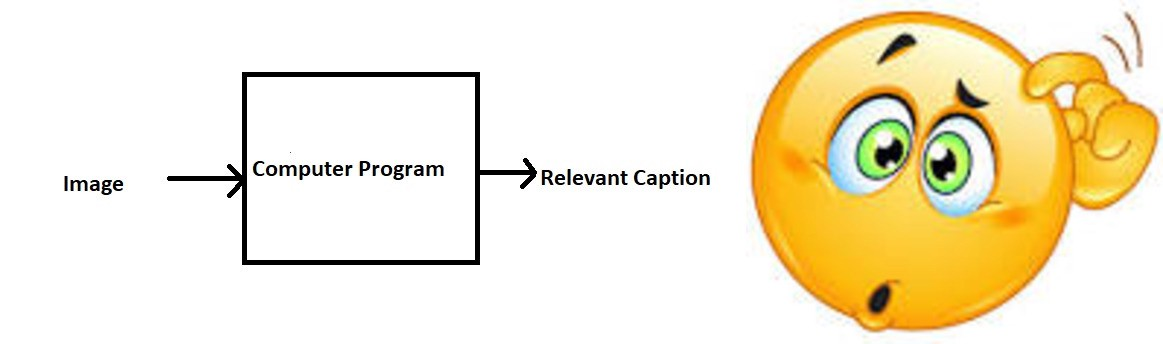

# Prerequisites:

1.Basic Deep Learning concepts like Multi-layered Perceptrons, Convolution Neural Networks, Recurrent Neural Networks, Transfer Learning, Gradient Descent, Backpropagation, Overfitting, Probability, Text Processing, Python syntax and data structures, Keras library, etc.

2.This dataset contains 8000 images each with 5 captions (an image can have multiple captions, all being relevant simultaneously) :

These images are bifurcated as follows:

                       Training Set — 6000 images:

                       Dev Set — 1000 images

                       Test Set — 1000 images

In [1]:
!pip install pillow

# Important Libraries need to be import

In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
import pickle
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


# captions related text file

1.Along with images, you will also get some text files related to the images.

2.One of the files is “Flickr8k.token.txt” which contains the name of each image along with its 5 captions. 

In [3]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = r"C://Users//addal//Downloads//Flickr8k_text//Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


# Just look the above content:

1.Every line contains the <image name>#i <caption>, where 0≤i≤4

i.e. the name of the image, caption number (0 to 4) and the actual caption.

2. we create a dictionary named “descriptions” which contains the name of the image (without the .jpg extension) as keys and a list of the 5 captions for the corresponding image as values.


In [4]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [ ]:
# After doing certain transformations on text file,finally stored in descriptions variable as dictionary format

list(descriptions.keys())[:5]

In [6]:
# Displaying keys in dictionary

descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
# Displaying values for particular key in dictionary

# Here every key(image) has 5 values (captions)

descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

# Data cleaning

1.When we deal with text, we generally perform some basic cleaning like lower-casing all the words (otherwise“hello” and “Hello” will be regarded as two separate words), removing special tokens (like ‘%’, ‘$’, ‘#’, etc.), eliminating words which contain numbers (like ‘hey199’, etc.).

In [8]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [9]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [10]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

# Finding unique words in image captions:

1.Create a vocabulary of all the unique words present across all the 8000*5 (i.e. 40000) image captions (corpus) in the data set :

2.If u see below output, 8763 unique words across all the 40000 image captions. We write all these captions along with their image names in a new file namely, “descriptions.txt” and save it on the disk.

In [11]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [12]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

# Names of training images:

1.The text file “Flickr_8k.trainImages.txt” contains the names of the images(6000) that belong to the training set. So we load these names into a list “train”.
2.We have separated the 6000 training images in the list named “train” from the total images(8000).

In [13]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = r"C://Users//addal//Downloads//Flickr8k_text//Flickr_8k.trainImages.txt"
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [ ]:
# load images
# Below path contains all the images
images = r"C://Users//addal//Downloads//Flicker8k_Dataset/"
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [15]:
img

['C://Users//addal//Downloads//Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'C://Users//addal//Downloads//Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'C://Users//addal//Downloads//Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'C://Users//addal//Downloads//Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'C://Users//addal//Downloads//Flicker8k_Dataset\\1007129816_e794419615.jpg',
 'C://Users//addal//Downloads//Flicker8k_Dataset\\1007320043_627395c3d8.jpg',
 'C://Users//addal//Downloads//Flicker8k_Dataset\\1009434119_febe49276a.jpg',
 'C://Users//addal//Downloads//Flicker8k_Dataset\\1012212859_01547e3f17.jpg',
 'C://Users//addal//Downloads//Flicker8k_Dataset\\1015118661_980735411b.jpg',
 'C://Users//addal//Downloads//Flicker8k_Dataset\\1015584366_dfcec3c85a.jpg',
 'C://Users//addal//Downloads//Flicker8k_Dataset\\101654506_8eb26cfb60.jpg',
 'C://Users//addal//Downloads//Flicker8k_Dataset\\101669240_b2d3e7f17b.jpg',
 'C://Users//addal//Downloads//Flicker8k_Dataset\\1016887272_03199

In [16]:
# Below file conatains the names of images(6000) to be used in train data
train_images_file = r"C://Users//addal//Downloads//Flickr8k_text//Flickr_8k.trainImages.txt"
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [17]:
# Below file conatains the names of images(1000) to be used in test data
test_images_file = r"C://Users//addal//Downloads//Flickr8k_text//Flickr_8k.testImages.txt"
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images
        
        

In [ ]:
# load the descriptions of these images from “descriptions.txt” (saved on the hard disk) in the Python dictionary “train_descriptions”.

In [18]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


# Data Preprocessing — Images

# Convert all the images to size 299x299 as expected by the inception v3 model

1.Images are nothing but input (X) to our model. Any input to a model must be given in the form of a vector.

2.We need to convert every image into a fixed sized vector which can then be fed as input to the neural network. 

3.This model was trained on Imagenet dataset to perform image classification on 1000 different classes of images. However, our purpose here is not to classify the image but just get fixed-length informative vector for each image. This process is called automatic feature engineering.

4.Hence, we just remove the last softmax layer from the model and extract a 2048 length vector (bottleneck features) for every image 

In [19]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [20]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [21]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [22]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [23]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 2557.9541008472443


In [24]:
# Save the bottleneck train features to disk
with open("C://Users//addal//Downloads//Pickle//encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [25]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 612.3063590526581


# Saving training & testing image features in pickle file

1.We save all the bottleneck train features in a Python dictionary and save it on the disk using Pickle file, namely “encoded_train_images.pkl” whose keys are image names and values are corresponding 2048 length feature vector.

In [26]:
# Save the bottleneck test features to disk
with open("C://Users//addal//Downloads//Pickle//encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [27]:
train_features = load(open("C://Users//addal//Downloads//Pickle//encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [28]:
# Create a list of all the training captions
# convert a dictionary of clean descriptions to a list of descriptions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

# Data preprocessing -- captions

1.captions are something that we want to predict. So during the training period, captions will be the target variables (Y) that the model is learning to predict.

2.But the prediction of the entire caption, given the image does not happen at once. We will predict the caption word by word.

3.we will represent every unique word in the vocabulary by an integer (index). As seen above, we have 1652 unique words in the corpus and thus each word will be represented by an integer index between 1 to 1652.

4.These two Python dictionaries can be used as follows:
5.wordtoix[‘abc’] -> returns index of the word ‘abc’
6.ixtoword[k] -> returns the word whose index is ‘k’

In [29]:
# Consider only words which occur at least 10 times in the corpus

word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [30]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [31]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

There is one more parameter that we need to calculate, i.e., the maximum length of a caption and we do it as below:

In [32]:
# convert a dictionary of clean descriptions to a list of descriptions

# To know the max length of captions

def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


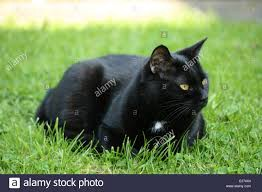

                                    (Train image 1) Caption -> The black cat sat on grass

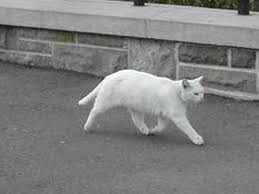

                                      (Train image 2) Caption -> The white cat is walking on road

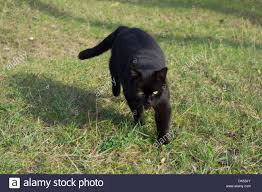

                                       (Test image) Caption -> The black cat is walking on grass

Consider we have 3 images and their 3 corresponding captions as follows:

1.we use the first two images and their captions to train the model and the third image to test our model.

2.First we need to convert both the images to their corresponding 2048 length feature vector.Let “Image_1” and “Image_2” be the feature vectors of the first two images respectively.

3.Secondly, let’s build the vocabulary for the first two (train) captions by adding the two tokens “startseq” and “endseq” in both of them: (Assume we have already performed the basic cleaning steps)

4.Caption_1 -> “startseq the black cat sat on grass endseq”

5.Caption_2 -> “startseq the white cat is walking on road endseq”

6.vocab = {black, cat, endseq, grass, is, on, road, sat, startseq, the, walking, white}
           
7.Let’s give an index to each word in the vocabulary:

  black -1, cat -2, endseq -3, grass -4, is -5, on -6, road -7, sat -8, startseq -9, the -10, walking -11, white -12
  
8.Let’s take the first image vector Image_1 and its corresponding caption “startseq the black cat sat on grass endseq”. Recall that, Image vector is the input and the caption is what we need to predict.

9.For the first time, we provide the image vector and the first word as input and try to predict the second word, i.e.:
               Input = Image_1 + ‘startseq’; Output = ‘the’

10.Then we provide image vector and the first two words as input and try to predict the third word, i.e.:
               Input = Image_1 + ‘startseq the’; Output = ‘cat’

11.Thus, we can summarize the data matrix for one image and its corresponding caption as follows:
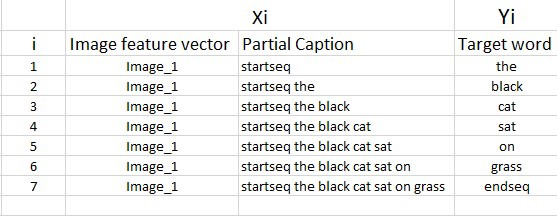



12.one image+caption is not a single data point but are multiple data points depending on the length of the caption.

13.Similarly if we consider both the images and their captions, our data matrix will then look as follows:

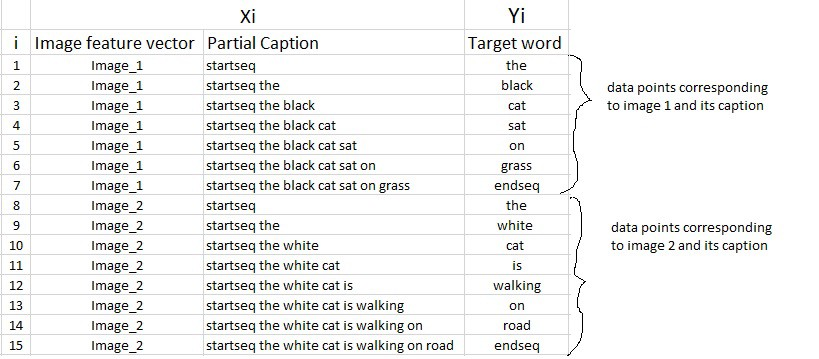

14.We must now understand that in every data point, it’s not just the image which goes as input to the system, but also, a   partial caption which helps to predict the next word in the sequence.

15.Since we are processing sequences, we will employ a Recurrent Neural Network to read these partial captions (more on this later).

16.However, we have already discussed that we are not going to pass the actual English text of the caption, rather we are going to pass the sequence of indices where each index represents a unique word.



In [33]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

# word embedding

1.we will map the every word (index) to a 200-long vector and for this purpose, we will use a pre-trained GLOVE Model:

2.Now, for all the 1652 unique words in our vocabulary, we create an embedding matrix which will be loaded into the model before training.

In [34]:
# Load Glove vectors
glove_dir = 'C://Users//addal//Downloads//glove//glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'),encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [35]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [36]:
embedding_matrix.shape

(1652, 200)

# Model architecture:

1.Since the input consists of two parts, an image vector and a partial caption, we cannot use the Sequential API provided by the Keras library. 
For this reason, we use the Functional API which allows us to create Merge Models.
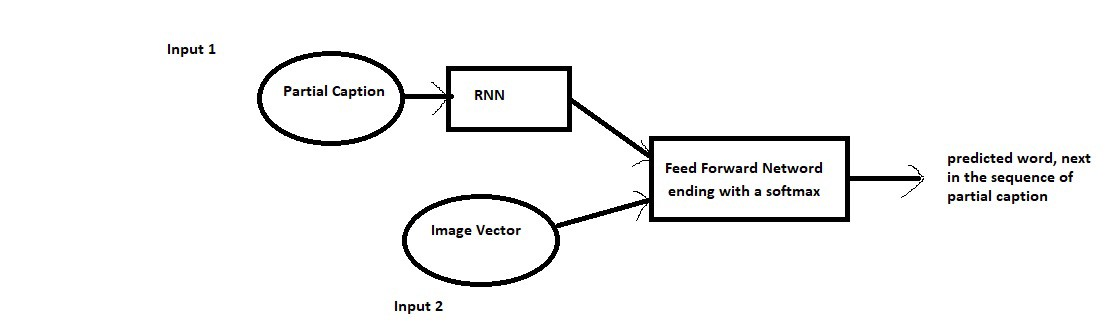


In [37]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [39]:
model.layers[2]

In [40]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [42]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [43]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 1017s 1s/step - loss: 5.1462
Epoch 1/1
1000/1000 [==============================] - 1019s 1s/step - loss: 4.4026
Epoch 1/1
1000/1000 [==============================] - 1019s 1s/step - loss: 4.0557
Epoch 1/1
1000/1000 [==============================] - 1020s 1s/step - loss: 3.8592
Epoch 1/1
1000/1000 [==============================] - 884s 884ms/step - loss: 3.7246
Epoch 1/1
1000/1000 [==============================] - 740s 740ms/step - loss: 3.6226
Epoch 1/1
1000/1000 [==============================] - 664s 664ms/step - loss: 3.5401
Epoch 1/1
1000/1000 [==============================] - 664s 664ms/step - loss: 3.4711
Epoch 1/1
1000/1000 [==============================] - 778s 778ms/step - loss: 3.4113
Epoch 1/1
1000/1000 [==============================] - 930s 930ms/step - loss: 3.3601


In [69]:
model.save_weights('C://Users//addal//Downloads//model_weights//model_30.h5')

In [71]:
model.load_weights("C://Users//addal//Downloads//model_weights//model_30.h5")

In [72]:
images = r"C://Users//addal//Downloads//Flicker8k_Dataset/"

In [73]:
with open("C://Users//addal//Downloads//Pickle//encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [74]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

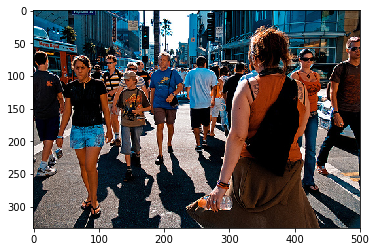

Greedy: group of people are walking down street


In [107]:
z=15
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

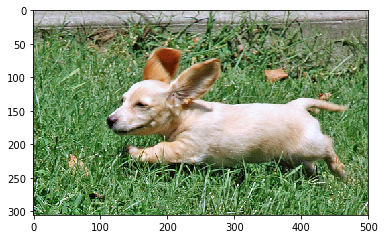

Greedy: dog is running through the grass


In [108]:
z=6
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

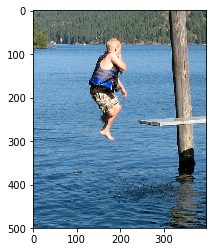

Greedy: man is jumping into the water


In [112]:
z=28
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

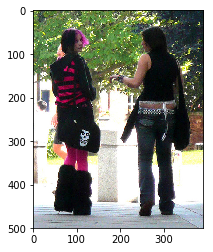

Greedy: two women are walking outside


In [119]:
z=46
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

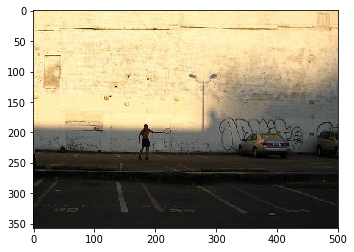

Greedy: the man is walking on the street


In [120]:
z=56
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

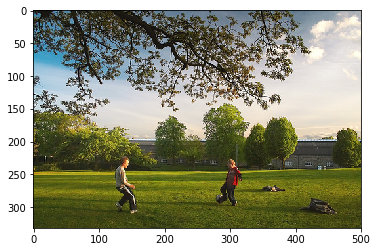

Greedy: two boys playing in field


In [128]:
z=74
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

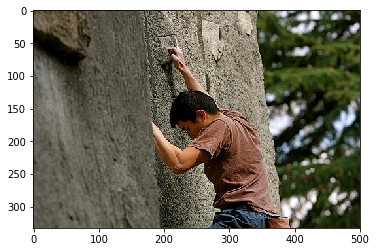

Greedy: young boy climbing rock wall


In [131]:
z=203
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))